# 3D Cylinder Demo

This is an example of a 3D reaction diffusion system.
- The domain is a cylinder
- Species `A` is created at the right end of the cylinder
- Species `B` is created at the left end of the cylinder
- Diffusion occurs throughout the volume of the cylinder
- `A` and `B` are destroyed on contact
- Deterministic and Stochastic simulations are run

This example allows us to check if reaction diffusion dynamics are accurate.

### Setup the Environment

In [1]:
import os
import sys
sys.path.insert(1, os.path.abspath(os.path.join(os.getcwd(), '../')))

In [2]:
import numpy

MatPlotLib is used for creating custom visualizations

In [3]:
import matplotlib.pyplot as plt

In [4]:
from spatialpy import (
    Model,
    Domain,
    Species,
    Parameter,
    Reaction,
    Geometry
)

## Create geometries for the domain
For custom geometries it is necessary to subclass the `Geometry` class that implements the `__init__` and `inside` methods. The `inside` method must return boolean value.

For this example we create three custom geometries: `Edge1`, `Edge2`, and `Middle`

In [5]:
class Edge1(Geometry):
    def __init__(self, xmax):
        self.xmax = xmax

    def inside(self, point, on_boundary):
        return abs(point[0] - self.xmax) < 0.05

In [6]:
class Edge2(Geometry):
    def __init__(self, xmin):
        self.xmin = xmin

    def inside(self, point, on_boundary):
        return abs(point[0] - self.xmin) < 0.05

In [7]:
class Middle(Geometry):
    def __init__(self, xmin):
        self.xmin = xmin

    def inside(self, point, on_boundary):
        return abs(point[0] - self.xmin) >= 0.05

## Creating a Fluid Dynamics Model using SpatialPy

In [8]:
class cylinderDemo3D(Model):
    # Define type IDs as constants of the Model
    MIDDLE = Middle.__name__
    EDGE1 = Edge1.__name__
    EDGE2 = Edge2.__name__
    
    def __init__(self, model_name="3D Cylinder Demo"):
        Model.__init__(self, model_name)

        # Set domain bounds
        xmin = -5
        xmax = 5
        
        # System constants
        D_const = 0.1

        """
        Create a domain from a FEniCS/dolfin style XML mesh file
        
        - filename: Name of the mesh file.
        """
        domain = Domain.read_xml_mesh(filename='Domain_Files/cylinder.xml')
        # Add type IDs to the particles
        """
        Update the prpoerties of particles within a geometric shape.

        - geometry_ivar: an instance of a 'spatialpy.Geometry' subclass.  The 'inside()' method
                         of this object will be used to add a single point particles.
        - type_id: Particle type ID of particle to be created.
        - vol: Default volume of particle to be added.
        - mass: Default mass of particle to be added.
        - nu: Default viscosity of particle to be created.
        - c: Default artificial speed of sound of particle to be created.
        - rho: Default density of particle to be created
        - fixed: True if particle is spatially fixed, else False.
        """
        domain.set_properties(Middle(xmin=xmin), self.MIDDLE)
        domain.set_properties(Edge1(xmax=xmax), self.EDGE1)
        domain.set_properties(Edge2(xmin=xmin), self.EDGE2)
        # Add the Domain to the Model
        self.add_domain(domain)

        # Define Species
        A = Species(name="A", diffusion_coefficient=D_const, restrict_to=[self.MIDDLE, self.EDGE1])
        B = Species(name="B", diffusion_coefficient=D_const, restrict_to=[self.MIDDLE, self.EDGE2])
        
        # Add the Species to the Model.
        self.add_species([A, B])

        # Define Parameters
        vol = self.domain.get_vol()
        type_id = self.domain.type_id
        left = numpy.sum(vol[type_id == self.domain.get_type_def(self.EDGE1)])
        right = numpy.sum(vol[type_id == self.domain.get_type_def(self.EDGE2)])
        
        k_react = Parameter(name="k_react", expression=1.0)
        k_creat1 = Parameter(name="k_creat1", expression=100 / left)
        k_creat2 = Parameter(name="k_creat2", expression=100 / right)
        
        # Add the Parameters to the Model.
        self.add_parameter([k_react, k_creat1, k_creat2])
        
        # Define Reactions
        R1 = Reaction(
            reactants={},
            products={"A":1},
            rate="k_creat1",
            restrict_to=self.EDGE1
        )
        
        R2 = Reaction(
            reactants={},
            products={"B":1},
            rate="k_creat2",
            restrict_to=self.EDGE2
        )
        
        R3 = Reaction(
            reactants={"A":1, "B":1},
            products={},
            rate="k_react"
        )
        
        # Add the Reactions to the Model.
        self.add_reaction([R1, R2, R3])
        
        """
        Use NumPy to set the timespan of the Model. Reaction diffusion examples may require a small
        timespan_size (around 1e-3) to generate accurate deterministic results.
        """
        self.timespan(numpy.linspace(0, 500, 501), timestep_size=1e-3)

### Instantiate your Model

In [9]:
model = cylinderDemo3D()

Lets preview our domain since we loaded it from a file

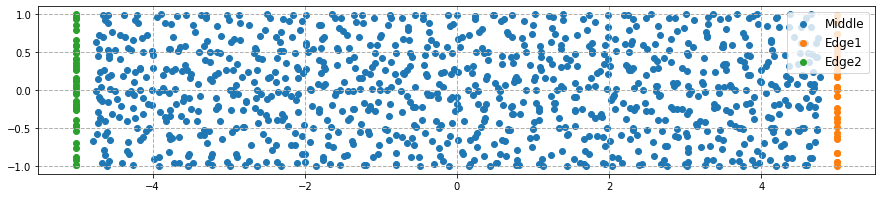

In [10]:
model.domain.plot_types(
    # Set to True to use MatPlotLib plotting
    use_matplotlib=True,
    
    # Set the width and height of the plot (for MatPlotLib these units are in inches)
    width=15,
    height=5
)

Lets look at it in a liitle more detail using plotly's 3D plotting

In [11]:
model.domain.plot_types(
    # Set the width and height of the plot (for MatPlotLib these units are in pixles)
    # width=auto defaults to 700, height=auto defaults to 450
    width="auto",
    height="auto"
)

## Running Simulations

In [12]:
results = model.run()

## Visualization
Plot the results of the simulation.

These plots tell us the accuracy of the simulation.  On the left is a plot of the population of both species over time.  You can see they are approaching steady-state levels as time goes on.  The plot on the left shows the time-averaged population over the space (i.e. the length of the cylinder along the x-axis). You can see that "B" is created on the left and "A" is created on the right, and the populations fall as you move towards the center of the cylinder.  At the center, the population is (almost) zero for both species, as they annihilate each other on contact. 

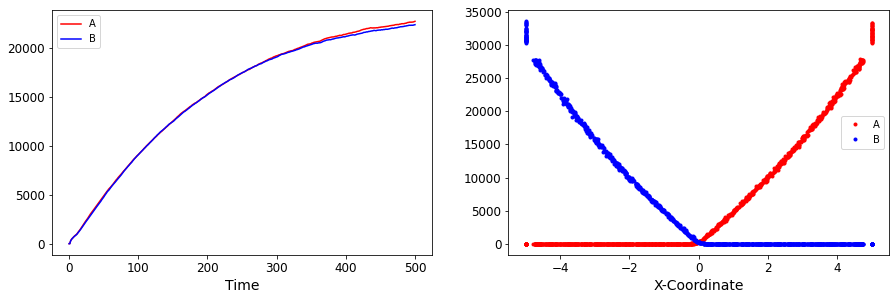

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4.5))

tspan = results.get_timespan()
A_sum = numpy.sum(results.get_species("A"), axis=1)
B_sum = numpy.sum(results.get_species("B"), axis=1)

ax1.plot(tspan, A_sum, '-r', label="A")
ax1.plot(tspan, B_sum, '-b', label="B")
ax1.set_xlabel("Time", fontsize=14)
ax1.tick_params(axis="x", labelsize=12)
ax1.tick_params(axis="y", labelsize=12)
_ = ax1.legend(loc='best')

x_vals = results.model.domain.coordinates()[:, 0]
A_vals = numpy.sum(results.get_species("A"), axis=0)
B_vals = numpy.sum(results.get_species("B"), axis=0)

ax2.plot(x_vals, A_vals, '.r')
ax2.plot(x_vals, B_vals, '.b')
ax2.set_xlabel("X-Coordinate", fontsize=14)
ax2.tick_params(axis="x", labelsize=12)
ax2.tick_params(axis="y", labelsize=12)
_ = ax2.legend(['A', 'B'], loc='best')

## Visualization
Plot the results of the simulation.

There are a multitude of arguments that can be set to tweak the behavior and visuals of the plot. 
For now though, lets plot the populations of `A` and `B` at the end of the simulation using MatPlotLib. Multiple species must be plotted separately.

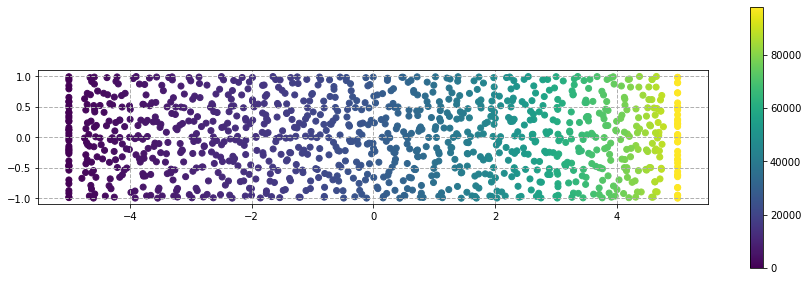

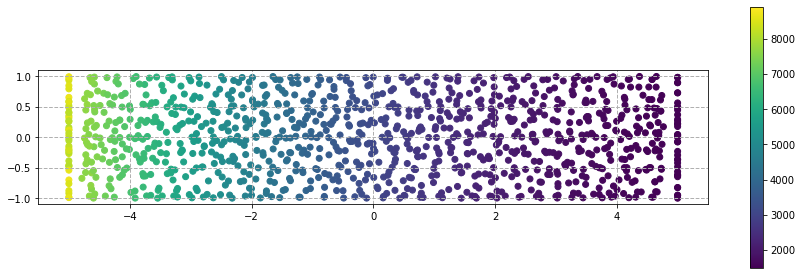

In [14]:
results.plot_species("A", t_val=500, deterministic=True, use_matplotlib=True, width=15)
results.plot_species("B", t_val=500, deterministic=True, use_matplotlib=True, width=15)

Lets look at these in more detail using plotly's 3D plotting

In [15]:
results.plot_species("A", t_val=500, deterministic=True, width="auto")
results.plot_species("B", t_val=500, deterministic=True, width="auto")

A more complete list of `results.plot_property()` arguments can be found in the [documentation](https://stochss.github.io/SpatialPy/docs/build/html/classes/spatialpy.core.html#spatialpy.core.result.Result.plot_species).